In [1]:
# Libraries
import numpy as np
import pandas as pd
import torch
from modules.energy_consumption_net import EnergyConsumptionNet, train_epochs
from modules.energy_consumption_dataset import EnergyConsumptionDataset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.colors as mc

# Register converters to plot datetime axis
pd.plotting.register_matplotlib_converters()

# Setup matplotlib plotting
%matplotlib inline

In [2]:
# Read dataset
ds = pd.read_csv('data/ready.csv', parse_dates=['datetime'], index_col='datetime')
# We want to have 2018 in last positions of the array (due to Neural Network layout)
# So, dataset is sorted accordingly
ds.sort_index(ascending=True, inplace=True)
# Show dataset
ds.head()

,AEP,DAYTON,DOM,DUQ
datetime,,,,
2006-01-01 00:00:00,14565.0,1769.0,9649.0,1493.0
2006-01-01 01:00:00,14287.0,1697.0,9258.0,1255.0
2006-01-01 02:00:00,13932.0,1635.0,8987.0,1338.0
2006-01-01 03:00:00,13713.0,1584.0,8781.0,1276.0
2006-01-01 04:00:00,13656.0,1553.0,8680.0,1251.0


In [3]:
# Retrieve region names from dataset
regions = ds.columns.tolist()
regions

['AEP', 'DAYTON', 'DOM', 'DUQ']

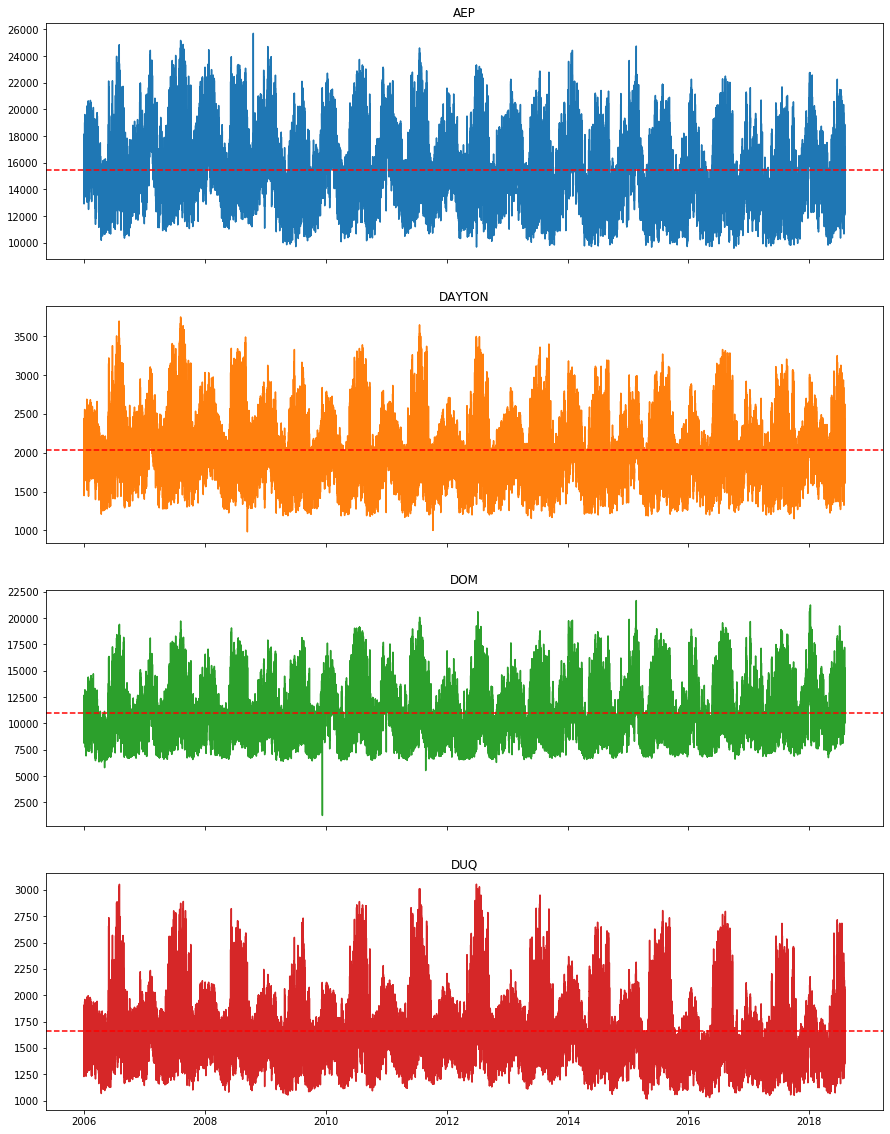

In [4]:
# Plot series separately
fig, axs = plt.subplots(len(regions), 1, figsize=(15, 20), sharex=True, sharey=False)
_ = plt.title('Hourly MWh consumption by region') # Set title

# Loop through each region and plot the relative timeseries
for i, region in enumerate(regions):
    _ = axs[i].set_title(region)
    _ = axs[i].plot(ds[region], color=[*mc.TABLEAU_COLORS.values()][i])
    _ = axs[i].axhline(y=ds[region].mean(), color='red', ls='--')
    
# Show plot
_ = plt.show()

In [5]:
# Check correlation among different series
corr = ds.corr()
corr

,AEP,DAYTON,DOM,DUQ
AEP,1.000000,0.943677,0.846235,0.865355
DAYTON,0.943677,1.000000,0.826334,0.904298
DOM,0.846235,0.826334,1.000000,0.844788
DUQ,0.865355,0.904298,0.844788,1.000000


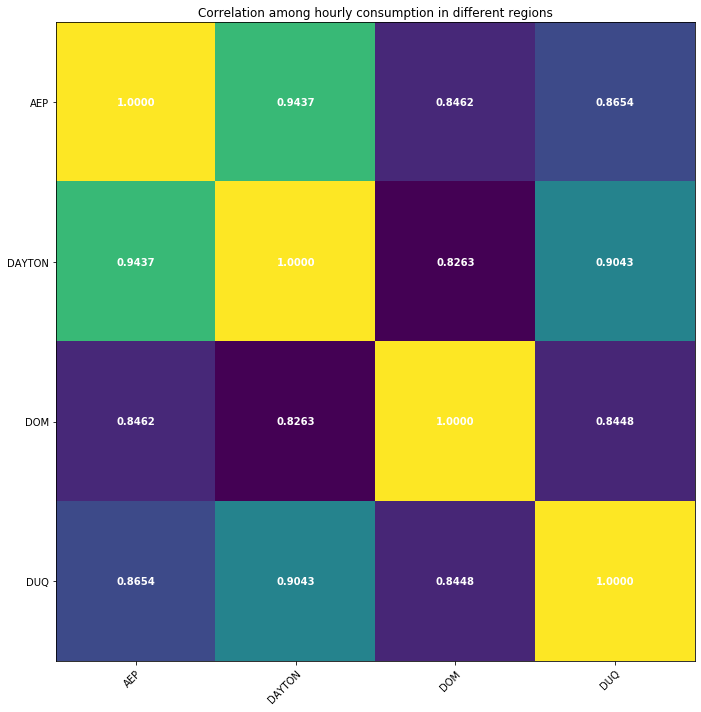

In [6]:
# Plot correlation metrix visually
fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.set_title('Correlation among hourly consumption in different regions')

# Customize ticks
_ = ax.set_xticks(range(len(regions)))
_ = ax.set_yticks(range(len(regions)))
_ = ax.set_xticklabels(regions)
_ = ax.set_yticklabels(regions)

# Rotate the tick labels and set their alignment.
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Customize text
for i in range(len(regions)):
    for j in range(len(regions)):
        _ = ax.text(j, i, '{:.4f}'.format(corr.values[i, j]), 
                    ha='center', va='center', color='w', weight='bold')
        
# Show image
_ = ax.imshow(corr.values, cmap='viridis', interpolation='nearest')
_ = fig.tight_layout()
_ = plt.show()

In [7]:
# Split original dataset into training and testing
train = ds.loc[:'2017-01-01 00:00:00']
test = ds.loc['2017-01-01 00:00:00':]

# Check train and test datasets
print('Train dataset has {:d} rows ({:.0f}%)'.format(train.shape[0], train.shape[0] / ds.shape[0] * 100))
print('Test dataset has {:d} rows ({:.0f}%)'.format(test.shape[0], test.shape[0] / ds.shape[0] * 100))

Train dataset has 96433 rows (87%)
Test dataset has 13897 rows (13%)


In [8]:
# Define PyTorch Datasets
lag = 3  # Lag
train = EnergyConsumptionDataset(train, lag=lag)
test = EnergyConsumptionDataset(test, col_max=train.max, col_min=train.min, lag=lag)

In [9]:
# Define network (10 lags)
ecnet3 = EnergyConsumptionNet(input_size=4, hidden_size=128, num_layers=2, dropout=0.3)
# Move net to GPU
ecnet3.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

EnergyConsumptionNet(
  (rnn): LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
"""# Train the net
train_loss = train_epochs(
    net=ecnet3, dataset=train, batch_size=5000, num_epochs=5, 
    optimizer=torch.optim.Adagrad(ecnet3.parameters()),
    verbose=True
)

# Save train loss
np.save('models/multivariate.npy', train_locc)

# Save the network to disk
torch.save(ecnet3.state_dict(), 'models/multivariate.pt')"""

"# Train the net\ntrain_loss = train_epochs(\n    net=ecnet3, dataset=train, batch_size=5000, num_epochs=5, \n    optimizer=torch.optim.Adagrad(ecnet3.parameters()),\n    verbose=True\n)\n\n# Save train loss\nnp.save('models/multivariate.npy', train_locc)\n\n# Save the network to disk\ntorch.save(ecnet3.state_dict(), 'models/multivariate.pt')"

In [40]:
# Load loss
train_loss = np.load('models/multivariate.npy').tolist()

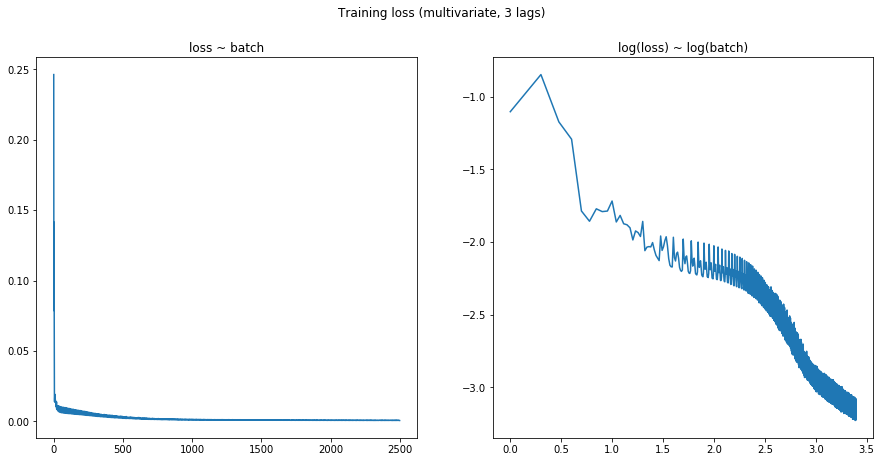

In [41]:
# Plot training loss

# Retrieve list of training losses
train_loss_ = [batch_loss for epoch_loss in train_loss for batch_loss in epoch_loss]

# Get a plot of the training loss
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
_ = fig.suptitle('Training loss (multivariate, 3 lags)')
_ = axs[0].plot(train_loss_, '-')
_ = axs[0].set_title('loss ~ batch')
_ = axs[1].plot(np.log10(list(range(1, len(train_loss_)))), np.log10(train_loss_[1:]), '-')
_ = axs[1].set_title('log(loss) ~ log(batch)')
_ = plt.show()

In [13]:
# Load weigths from disk
ecnet3.load_state_dict(torch.load('models/multivariate.pt'))

<All keys matched successfully>

In [15]:
# Predict using training and test data

# Retrieve network object on current device
ecnet3 = ecnet3.to(torch.device('cpu'))

# Predict on whole training dataset
with torch.no_grad():
    # Set the net in evaluation mode (activate dropout)
    ecnet3.train()

    # Define datetime indices for every predicted value
    train_index = train.dataset.index[train.lag:]
    test_index = test.dataset.index[test.lag:]

    # Make predictions on train set
    x_train = torch.cat([train[i].unsqueeze(0) for i in range(len(train))])
    # Predict using train set many times, keeping dropout activated
    # train_pred = torch.cat([ecnet3(x_train[:, :-1, :])[0] for i in range(2)])
    # print(train_pred.shape)
    train_pred, _ = ecnet3(x_train[:, :-1, :])
    
    # Make predictions on test set
    x_test = torch.cat([test[i].unsqueeze(0) for i in range(len(test))])
    # Predict using test set many times, keeping dropout activated
    # test_pred = torch.cat([ecnet3(x_test[:, :-1, :])[0] for i in range(2)])
    # print(test_pred.shape)
    test_pred, _ = ecnet3(x_test[:, :-1, :])
    
# Cast retrieved forecast as lists
train_pred = train_pred[:, -1, 0].squeeze().numpy()
test_pred = test_pred[:, -1, 0].squeeze().numpy()

In [16]:
# Rescale output
train_pred = train_pred * (train.max[0] - train.min[0]) + train.min[0]
test_pred = test_pred * (train.max[0] - train.min[0]) + train.min[0]

In [17]:
# Define datetime -> (true, train, test) dataset for forecasting
forecast = ds[['AEP']].copy().rename(columns={ds.columns[0]: 'true'})
# Add empty columns: train and test
forecast['train'] = np.nan
forecast['test'] = np.nan

In [18]:
# Fill forecast dataset with train and test data

# Fill training data
forecast.loc[train_index, 'train'] = np.array(train_pred)
# Fill test data
forecast.loc[test_index, 'test'] = np.array(test_pred)
# Check forecast dataset
forecast.head()

,true,train,test
datetime,,,
2006-01-01 00:00:00,14565.0,NaN,NaN
2006-01-01 01:00:00,14287.0,NaN,NaN
2006-01-01 02:00:00,13932.0,NaN,NaN
2006-01-01 03:00:00,13713.0,13681.205078,NaN
2006-01-01 04:00:00,13656.0,13509.630859,NaN


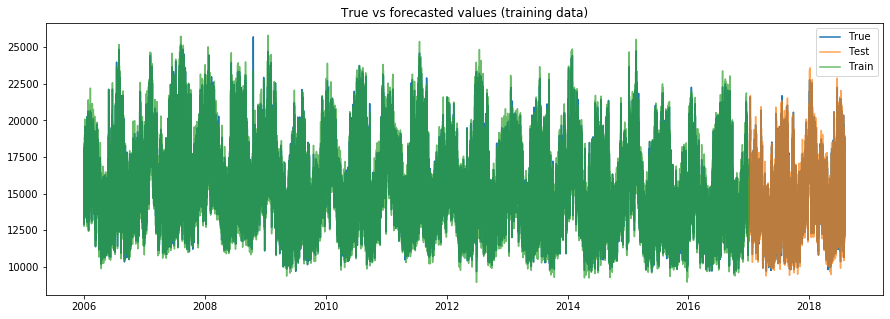

In [19]:
# Plot forecast using training data
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('True vs forecasted values (training data)')
_ = ax.plot(forecast.true, '-')
_ = ax.plot(forecast.test, '-', alpha=.7)
_ = ax.plot(forecast.train, '-', alpha=.7)
_ = ax.legend(['True', 'Test', 'Train'], loc='upper right')
_ = plt.show()

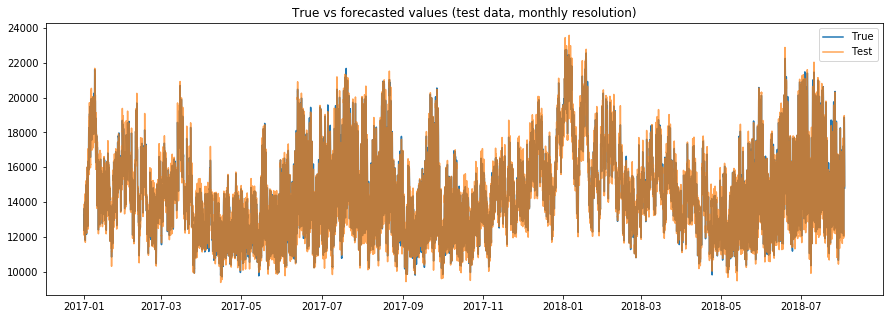

In [20]:
# Zoom in: get only a year aroung 2017-2018
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('True vs forecasted values (test data, monthly resolution)')
_ = ax.plot(forecast['2017-01-01 00:00:00':].true, '-')
_ = ax.plot(forecast['2017-01-01 00:00:00':].test, '-', alpha=.7)
_ = ax.legend(['True', 'Test'], loc='upper right')
_ = plt.show()

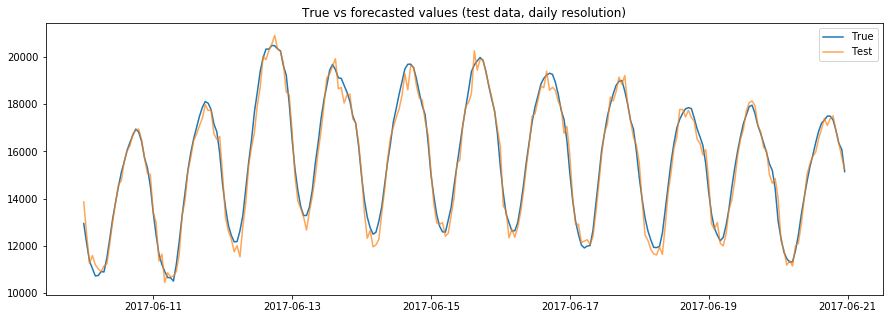

In [21]:
# Zoom in: get only a few days
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('True vs forecasted values (test data, daily resolution)')
_ = ax.plot(forecast['2017-06-10 00:00:00':'2017-06-20 23:00:00'].true, '-')
_ = ax.plot(forecast['2017-06-10 00:00:00':'2017-06-20 23:00:00'].test, '-', alpha=.7)
_ = ax.legend(['True', 'Test'], loc='upper right')
_ = plt.show()

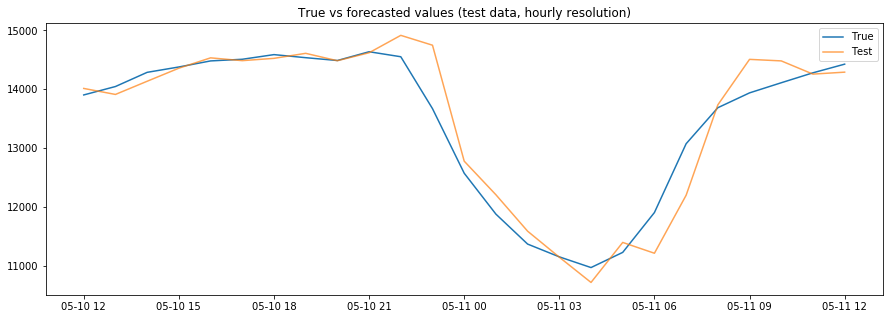

In [42]:
# Zoom in: get only a few hours
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('True vs forecasted values (test data, hourly resolution)')
_ = ax.plot(forecast['2017-05-10 12:00:00':'2017-05-11 12:00:00'].true, '-')
_ = ax.plot(forecast['2017-05-10 12:00:00':'2017-05-11 12:00:00'].test, '-', alpha=.7)
_ = ax.legend(['True', 'Test'], loc='upper right')
_ = plt.savefig('images/multivariate_test_hourly.png')
_ = plt.show()

In [33]:
# Define test and train differences
train_diff = forecast.true[~forecast.train.isnull()] - forecast.train[~forecast.train.isnull()]
test_diff = forecast.true[~forecast.test.isnull()] - forecast.test[~forecast.test.isnull()]

# Get Root Mean Squared Error (RMSE) on training set
train_rmse = np.sqrt(np.mean(train_diff.values**2))
print('RMSE on train set: {:.02f}'.format(train_rmse))

# Get Root Mean Squared Error (RMSE) on test set
test_rmse = np.sqrt(np.mean(test_diff.values**2))
print('RMSE on test set: {:.02f}'.format(test_rmse))

RMSE on train set: 437.31
RMSE on test set: 372.98


In [39]:
# Get Mean Absolute Error (MAE) on training set
train_mae = np.mean(np.absolute(train_diff.values))
print('MAE on train set: {:.02f}'.format(train_mae))

# Get Mean Absolute Error (MAE) on test set
test_mae = np.mean(np.absolute(test_diff.values))
print('MAE on test set: {:.02f}'.format(test_mae))

MAE on train set: 335.31
MAE on test set: 289.82
